In [1]:
cd ../

/Users/msandora/Work


/Users/msandora/Work/menv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from profiler_analyzer import ProfilerAnalyzer
p = ProfilerAnalyzer("/Users/msandora/Downloads/fit-profiler_report.txt")
report = p.parse_profiler_report()
dfr = pd.DataFrame([{i:getattr(r,i) for i in dir(r) if i[0]!='_'} for r in report])


In [5]:
report = p.parse_profiler_report()

In [37]:
import pandas as pd
dfr = pd.DataFrame([{i:getattr(r,i) for i in dir(r) if i[0]!='_'} for r in report])
dfb = dfr[dfr.top_bottlenecks.apply(len)>0].sort_values('total_time',ascending=False)
dfb

,component_type,function_calls,name,top_bottlenecks,total_time
114,LightningDataModule,1679653,GeneDataModule.setup,"[(datasets_with_gene_embeddings.py:876(setup),...",178.314
1,LightningDataModule,1679653,GeneDataModule.setup,"[(datasets_with_gene_embeddings.py:876(setup),...",178.061
182,Strategy,14693608,SingleDeviceStrategy.training_step,"[(model.py:180(forward), 51.89, 0.208), (modul...",63.966
69,Strategy,14749643,SingleDeviceStrategy.training_step,"[(module.py:1755(_call_impl), 55.702, 0.048), ...",62.781
175,_TrainingEpochLoop,66945,.train_dataloader_next,"[(pin_memory.py:35(do_one_step), 4.116, 0.242)...",4.317
26,_EvaluationLoop,13255,.val_next,"[({built-in method builtins.next}, 2.55, 1.275...",2.604
139,_EvaluationLoop,13196,.val_next,"[({built-in method builtins.next}, 2.562, 0.85...",2.564
148,Strategy,150217,SingleDeviceStrategy.validation_step,"[(connection.py:510(Client), 1.155, 0.02), (re...",1.490
35,Strategy,151721,SingleDeviceStrategy.validation_step,"[(reduction.py:186(recv_handle), 0.947, 0.014)...",1.345
206,LightningModule,236255,Seq2GenePredictor.configure_gradient_clipping,"[(module.py:1144(clip_gradients), 1.005, 0.02)...",1.069


In [30]:
dfr.head(10)

,component_type,function_calls,name,top_bottlenecks,total_time
0,LightningModule,7,Seq2GenePredictor.configure_callbacks,[],0.000
1,LightningDataModule,1679653,GeneDataModule.setup,"[(datasets_with_gene_embeddings.py:876(setup),...",178.061
2,Callback,10,ModelSummary.setup,[],0.000
3,Callback,125,"ModelCheckpoint{'monitor': None, 'mode': 'min'...",[],0.001
4,Callback,10,__MlflowPLCallback.setup,[],0.000
5,LightningModule,7,Seq2GenePredictor.setup,[],0.000
6,LightningModule,508929,Seq2GenePredictor.configure_optimizers,"[(model.py:761(configure_optimizers), 0.125, 0...",0.125
7,LightningDataModule,668,GeneDataModule.train_dataloader,[],0.001
8,Callback,224772,ModelSummary.on_fit_start,[],0.055
9,Callback,10,"ModelCheckpoint{'monitor': None, 'mode': 'min'...",[],0.000


In [31]:
dfr.component_type.value_counts()

component_type
Callback               132
LightningModule         62
Strategy                20
LightningDataModule      8
_EvaluationLoop          2
_TrainingEpochLoop       2
Name: count, dtype: int64

In [32]:
dfr.top_bottlenecks.apply(len).value_counts()

top_bottlenecks
0     208
10     12
8       3
1       1
4       1
2       1
Name: count, dtype: int64

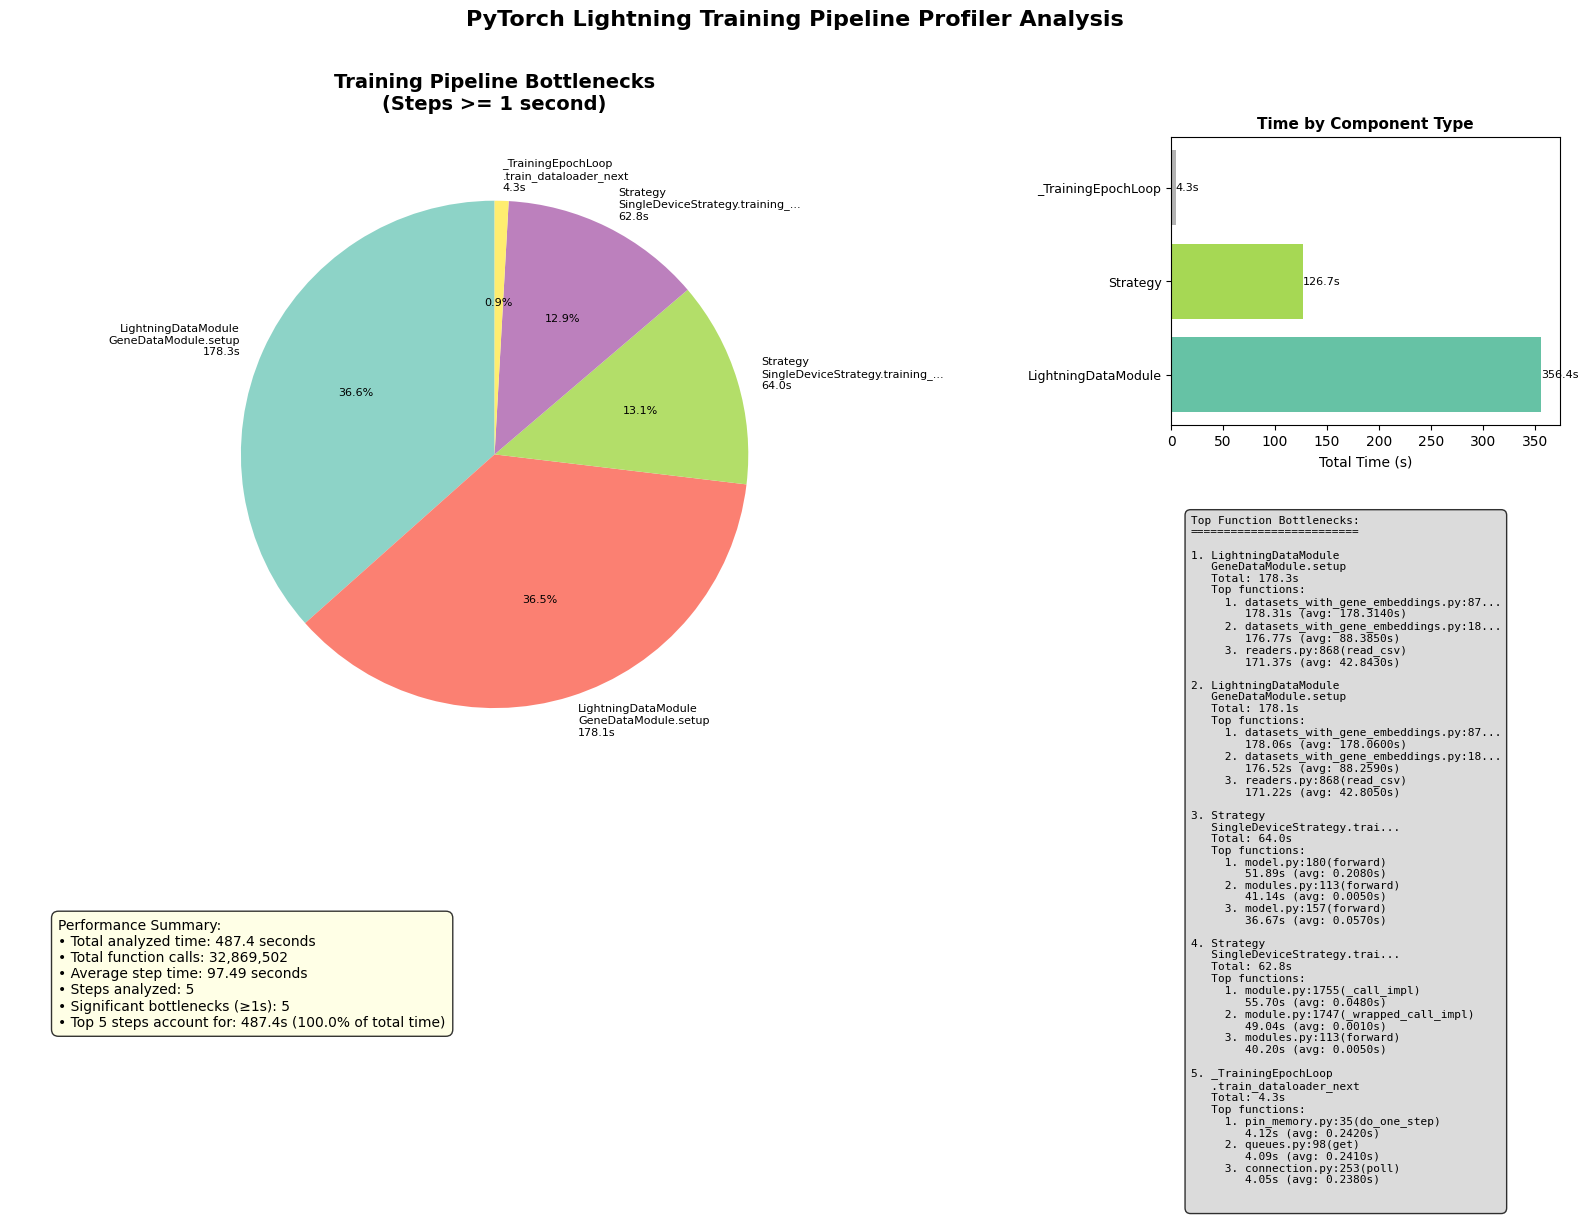

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from profiler_analyzer import ProfilerAnalyzer

def create_bottleneck_pie_chart(dfr):
    """
    Create a pie chart visualization of bottleneck steps with inlay details.
    
    Args:
        dfr: DataFrame with columns: name, component_type, total_time, function_calls, top_bottlenecks
    """
    # Filter out steps with minimal time (< 1 second) for cleaner visualization
    significant_steps = dfr[dfr['total_time'] >= 1.0].copy()
    
    if len(significant_steps) == 0:
        print("No significant bottlenecks found (>= 1 second)")
        return
    
    # Sort by total time and take top 10 for readability
    top_steps = significant_steps.nlargest(10, 'total_time')
    
    # Prepare data for pie chart
    labels = []
    sizes = []
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_steps)))
    
    for _, row in top_steps.iterrows():
        # Create compact labels
        component = row['component_type']
        name = row['name'][:30] + "..." if len(row['name']) > 30 else row['name']
        label = f"{component}\n{name}\n{row['total_time']:.1f}s"
        labels.append(label)
        sizes.append(row['total_time'])
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Main pie chart
    ax_pie = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
    wedges, texts, autotexts = ax_pie.pie(sizes, labels=labels, colors=colors, 
                                         autopct='%1.1f%%', startangle=90,
                                         textprops={'fontsize': 8})
    
    ax_pie.set_title('Training Pipeline Bottlenecks\n(Steps >= 1 second)', 
                     fontsize=14, fontweight='bold', pad=20)
    
    # Component type summary (top right)
    ax_summary = plt.subplot2grid((3, 3), (0, 2))
    component_times = top_steps.groupby('component_type')['total_time'].sum().sort_values(ascending=False)
    
    y_pos = np.arange(len(component_times))
    bars = ax_summary.barh(y_pos, component_times.values, 
                          color=plt.cm.Set2(np.linspace(0, 1, len(component_times))))
    ax_summary.set_yticks(y_pos)
    ax_summary.set_yticklabels(component_times.index, fontsize=9)
    ax_summary.set_xlabel('Total Time (s)', fontsize=10)
    ax_summary.set_title('Time by Component Type', fontsize=11, fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, component_times.values)):
        ax_summary.text(value + 0.1, i, f'{value:.1f}s', 
                       va='center', ha='left', fontsize=8)
    
    # Top bottlenecks details (bottom section)
    ax_details = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
    ax_details.axis('off')
    
    # Create detailed breakdown of top bottlenecks
    details_text = "Top Function Bottlenecks:\n" + "="*25 + "\n\n"
    
    for i, (_, row) in enumerate(top_steps.head(5).iterrows(), 1):
        step_name = row['name'][:25] + "..." if len(row['name']) > 25 else row['name']
        details_text += f"{i}. {row['component_type']}\n"
        details_text += f"   {step_name}\n"
        details_text += f"   Total: {row['total_time']:.1f}s\n"
        
        # Show top 3 function bottlenecks for this step
        if row['top_bottlenecks'] and len(row['top_bottlenecks']) > 0:
            details_text += "   Top functions:\n"
            for j, (func_name, cumtime, percall) in enumerate(row['top_bottlenecks'][:3], 1):
                # Truncate long function names
                func_short = func_name[:35] + "..." if len(func_name) > 35 else func_name
                details_text += f"     {j}. {func_short}\n"
                details_text += f"        {cumtime:.2f}s (avg: {percall:.4f}s)\n"
        details_text += "\n"
    
    ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes, 
                   fontsize=8, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    # Summary statistics (bottom left)
    ax_stats = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    ax_stats.axis('off')
    
    total_time = dfr['total_time'].sum()
    total_calls = dfr['function_calls'].sum()
    avg_time = dfr['total_time'].mean()
    
    stats_text = f"""
Performance Summary:
• Total analyzed time: {total_time:.1f} seconds
• Total function calls: {total_calls:,}
• Average step time: {avg_time:.2f} seconds
• Steps analyzed: {len(dfr)}
• Significant bottlenecks (≥1s): {len(significant_steps)}
• Top {len(top_steps)} steps account for: {top_steps['total_time'].sum():.1f}s ({(top_steps['total_time'].sum()/total_time*100):.1f}% of total time)
    """.strip()
    
    ax_stats.text(0.05, 0.5, stats_text, transform=ax_stats.transAxes, 
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('PyTorch Lightning Training Pipeline Profiler Analysis\n\n', 
                fontsize=16, fontweight='bold', y=1.04)
    
    return fig

f = create_bottleneck_pie_chart(dfb.head(5))